# Plot signal 

In [6]:

import bilby
import matplotlib.pyplot as plt
import numpy as np
from bilby.core.utils import (
    infft, logger, latex_plot_format
)
from bilby.gw.utils import asd_from_freq_series
from matplotlib import rcParams
import logging
logger.setLevel(logging.ERROR)

def setup_data(fref, injection_parameters):
    np.random.seed(0)

    duration = 4.
    sampling_frequency = 2048.


    waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                              reference_frequency=fref,
                              minimum_frequency=20)


    waveform_generator = bilby.gw.WaveformGenerator(
        duration=duration, sampling_frequency=sampling_frequency,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=waveform_arguments)


    ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
    ifos.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency, duration=duration,
        start_time=injection_parameters['geocent_time'] - 3)
    ifos.inject_signal(waveform_generator=waveform_generator,
                       parameters=injection_parameters)
    
    return injection_parameters, ifos, waveform_generator



@latex_plot_format
def plot_interferometer_waveform_posterior(interferometer, waveform_generator, level=0.9, n_samples=None, start_time=None,
                                           end_time=None, outdir='.', signals_to_plot={}, sampling_frequency=4096):
    DATA_COLOR = "#ff7f0e"
    WAVEFORM_COLOR = "#1f77b4"
    INJECTION_COLOR = "#000000"

    if not isinstance(interferometer, bilby.gw.detector.Interferometer):
        raise TypeError('interferometer type must be Interferometer')

    logger.info("Generating waveform figure for {}".format(interferometer.name))


    if start_time==None:
        start_time = interferometer.strain_data.start_time
        end_time = start_time + interferometer.strain_data.duration
        
    

    time_idxs = (
            (interferometer.time_array >= start_time) &
            (interferometer.time_array <= end_time)
    )
    frequency_idxs = np.where(interferometer.frequency_mask)[0]
    logger.debug("Frequency mask contains {} values".format(
        len(frequency_idxs))
    )
    frequency_idxs = frequency_idxs[::max(1, len(frequency_idxs) // 4000)]
    logger.debug("Downsampling frequency mask to {} values".format(
        len(frequency_idxs))
    )
    plot_times = interferometer.time_array[time_idxs]
    plot_times -= interferometer.strain_data.start_time
    start_time -= interferometer.strain_data.start_time
    end_time -= interferometer.strain_data.start_time
    plot_frequencies = interferometer.frequency_array[frequency_idxs]


    old_font_size = rcParams["font.size"]
    rcParams["font.size"] = 20
    fig, axs = plt.subplots(
        2, 1,
        gridspec_kw=dict(height_ratios=[1.5, 1]),
        figsize=(16, 12.5)
    )

    axs[0].loglog(
        plot_frequencies,
        asd_from_freq_series(
            interferometer.frequency_domain_strain[frequency_idxs],
            1 / interferometer.strain_data.duration),
        color=DATA_COLOR, label='Data', alpha=0.3)
    axs[0].loglog(
        plot_frequencies,
        interferometer.amplitude_spectral_density_array[frequency_idxs],
        color=DATA_COLOR, label='ASD')
    axs[1].plot(
        plot_times, infft(
            interferometer.whitened_frequency_domain_strain *
            np.sqrt(2. / interferometer.sampling_frequency),
            sampling_frequency=interferometer.strain_data.sampling_frequency)[time_idxs],
        color=DATA_COLOR, alpha=0.3)
    logger.debug('Plotted interferometer data.')


    if len(signals_to_plot) > 0:
        for d in signals_to_plot:
            params = d['params']
            label = d['label']
            col = d['color']
            try:
                hf_inj = waveform_generator.frequency_domain_strain(params)
                hf_inj_det = interferometer.get_detector_response(hf_inj, params)
                ht_inj_det = infft(
                    hf_inj_det * np.sqrt(2. / interferometer.sampling_frequency) /
                    interferometer.amplitude_spectral_density_array,
                    sampling_frequency)[time_idxs]

                axs[0].loglog(
                    plot_frequencies,
                    asd_from_freq_series(
                        hf_inj_det[frequency_idxs],
                        1 / interferometer.strain_data.duration),
                    label=label, linestyle=':', color=col)
                axs[1].plot(plot_times, ht_inj_det, linestyle=':', color=col)
                logger.debug('Plotted injection.')
            except IndexError as e:
                logger.info('Failed to plot injection with message {}.'.format(e))

    f_domain_x_label = "$f [\\mathrm{Hz}]$"
    f_domain_y_label = "$\\mathrm{ASD} \\left[\\mathrm{Hz}^{-1/2}\\right]$"
    t_domain_x_label = "$t - {} [s]$".format(interferometer.strain_data.start_time)
    t_domain_y_label = "Whitened Strain"

    axs[0].set_xlim(interferometer.minimum_frequency,
                    interferometer.maximum_frequency)
    axs[1].set_xlim(start_time, end_time)
    axs[0].set_xlabel(f_domain_x_label)
    axs[0].set_ylabel(f_domain_y_label)
    axs[1].set_xlabel(t_domain_x_label)
    axs[1].set_ylabel(t_domain_y_label)
    axs[0].legend(loc='lower left', ncol=2)


    plt.tight_layout()
    logger.info("Waveform figure complete")
    rcParams["font.size"] = old_font_size
    plt.show()



In [2]:
from ipywidgets import interactive, FloatSlider



def plot_injection_at_fref(fref=50, dl=100.0):
    injection_parameters = dict(
    mass_1=36., mass_2=29., a_1=0.4, a_2=0.3, tilt_1=0.5, tilt_2=1.0,
    phi_12=1.7, phi_jl=0.3, luminosity_distance=dl, theta_jn=0.4, psi=2.659,
    phase=1.3, geocent_time=1126259642.413, ra=1.375, dec=-1.2108)

    injection_parameters, ifos, waveform_generator = setup_data(fref, injection_parameters)
    plot_interferometer_waveform_posterior(
        ifos[0], waveform_generator,
        signals_to_plot=[dict(params=injection_parameters, label=f'fref={fref}Hz', color="tab:blue")]
    )
    
interactive(
    plot_injection_at_fref, 
    fref=FloatSlider(min=0.001,  max=100, continuous_update=False), 
    dl=FloatSlider(min=100.0, max=2000.0, continuous_update=False)
)

interactive(children=(FloatSlider(value=0.001, continuous_update=False, description='fref', min=0.001), FloatS…

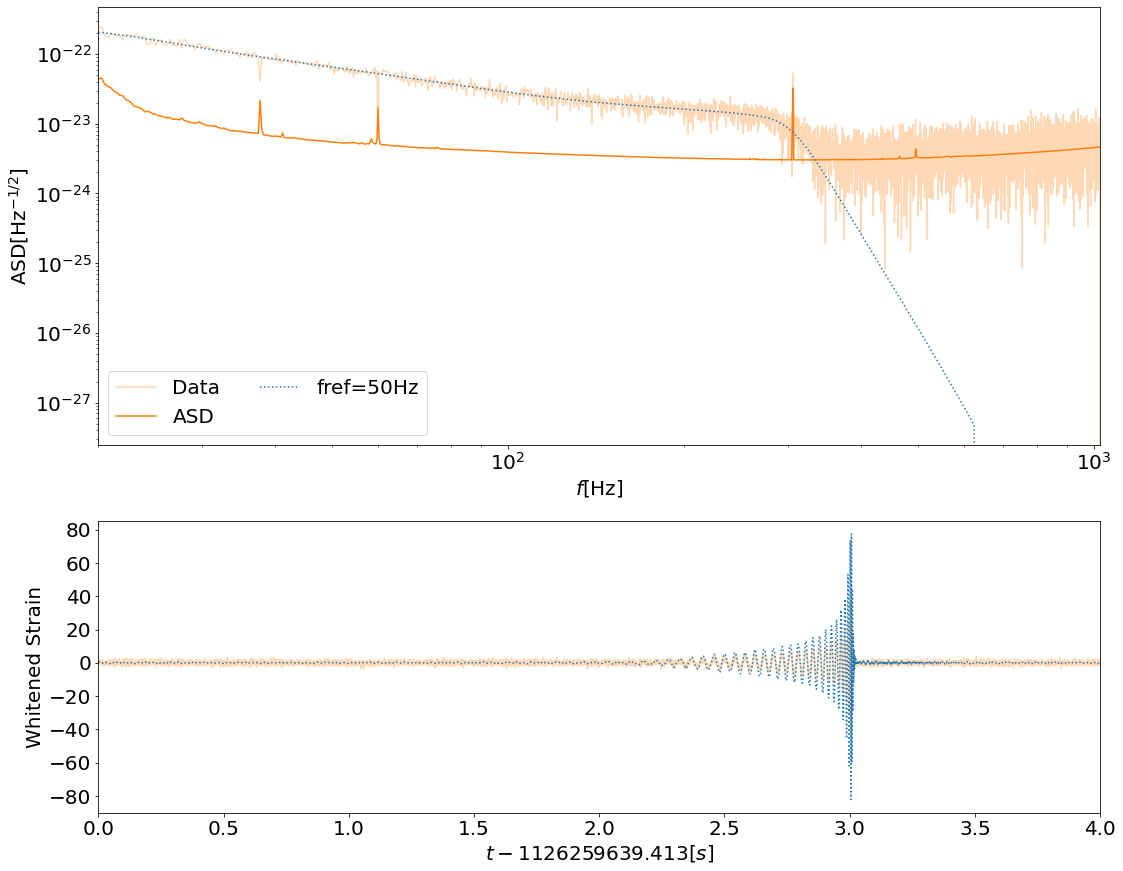

In [7]:
plot_injection_at_fref(fref=50, dl=100.0)

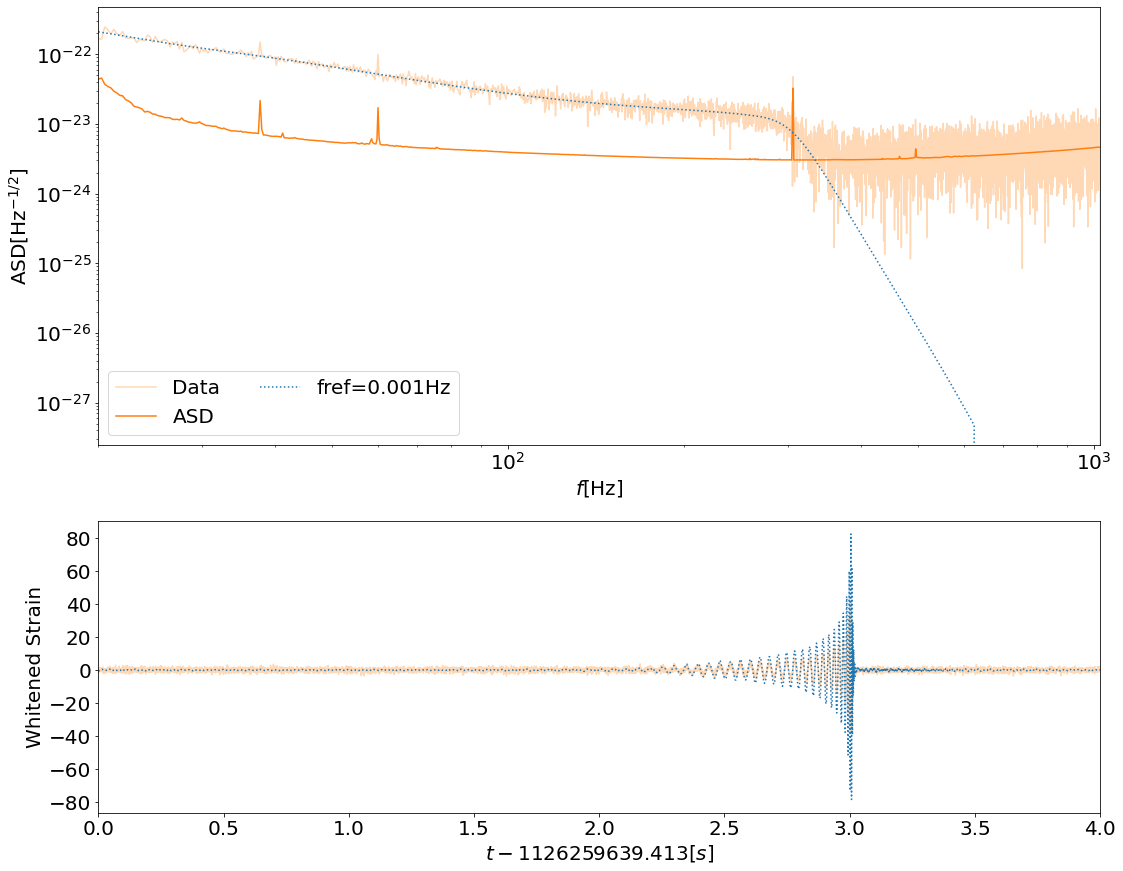

In [8]:
plot_injection_at_fref(fref=0.001, dl=100.0)

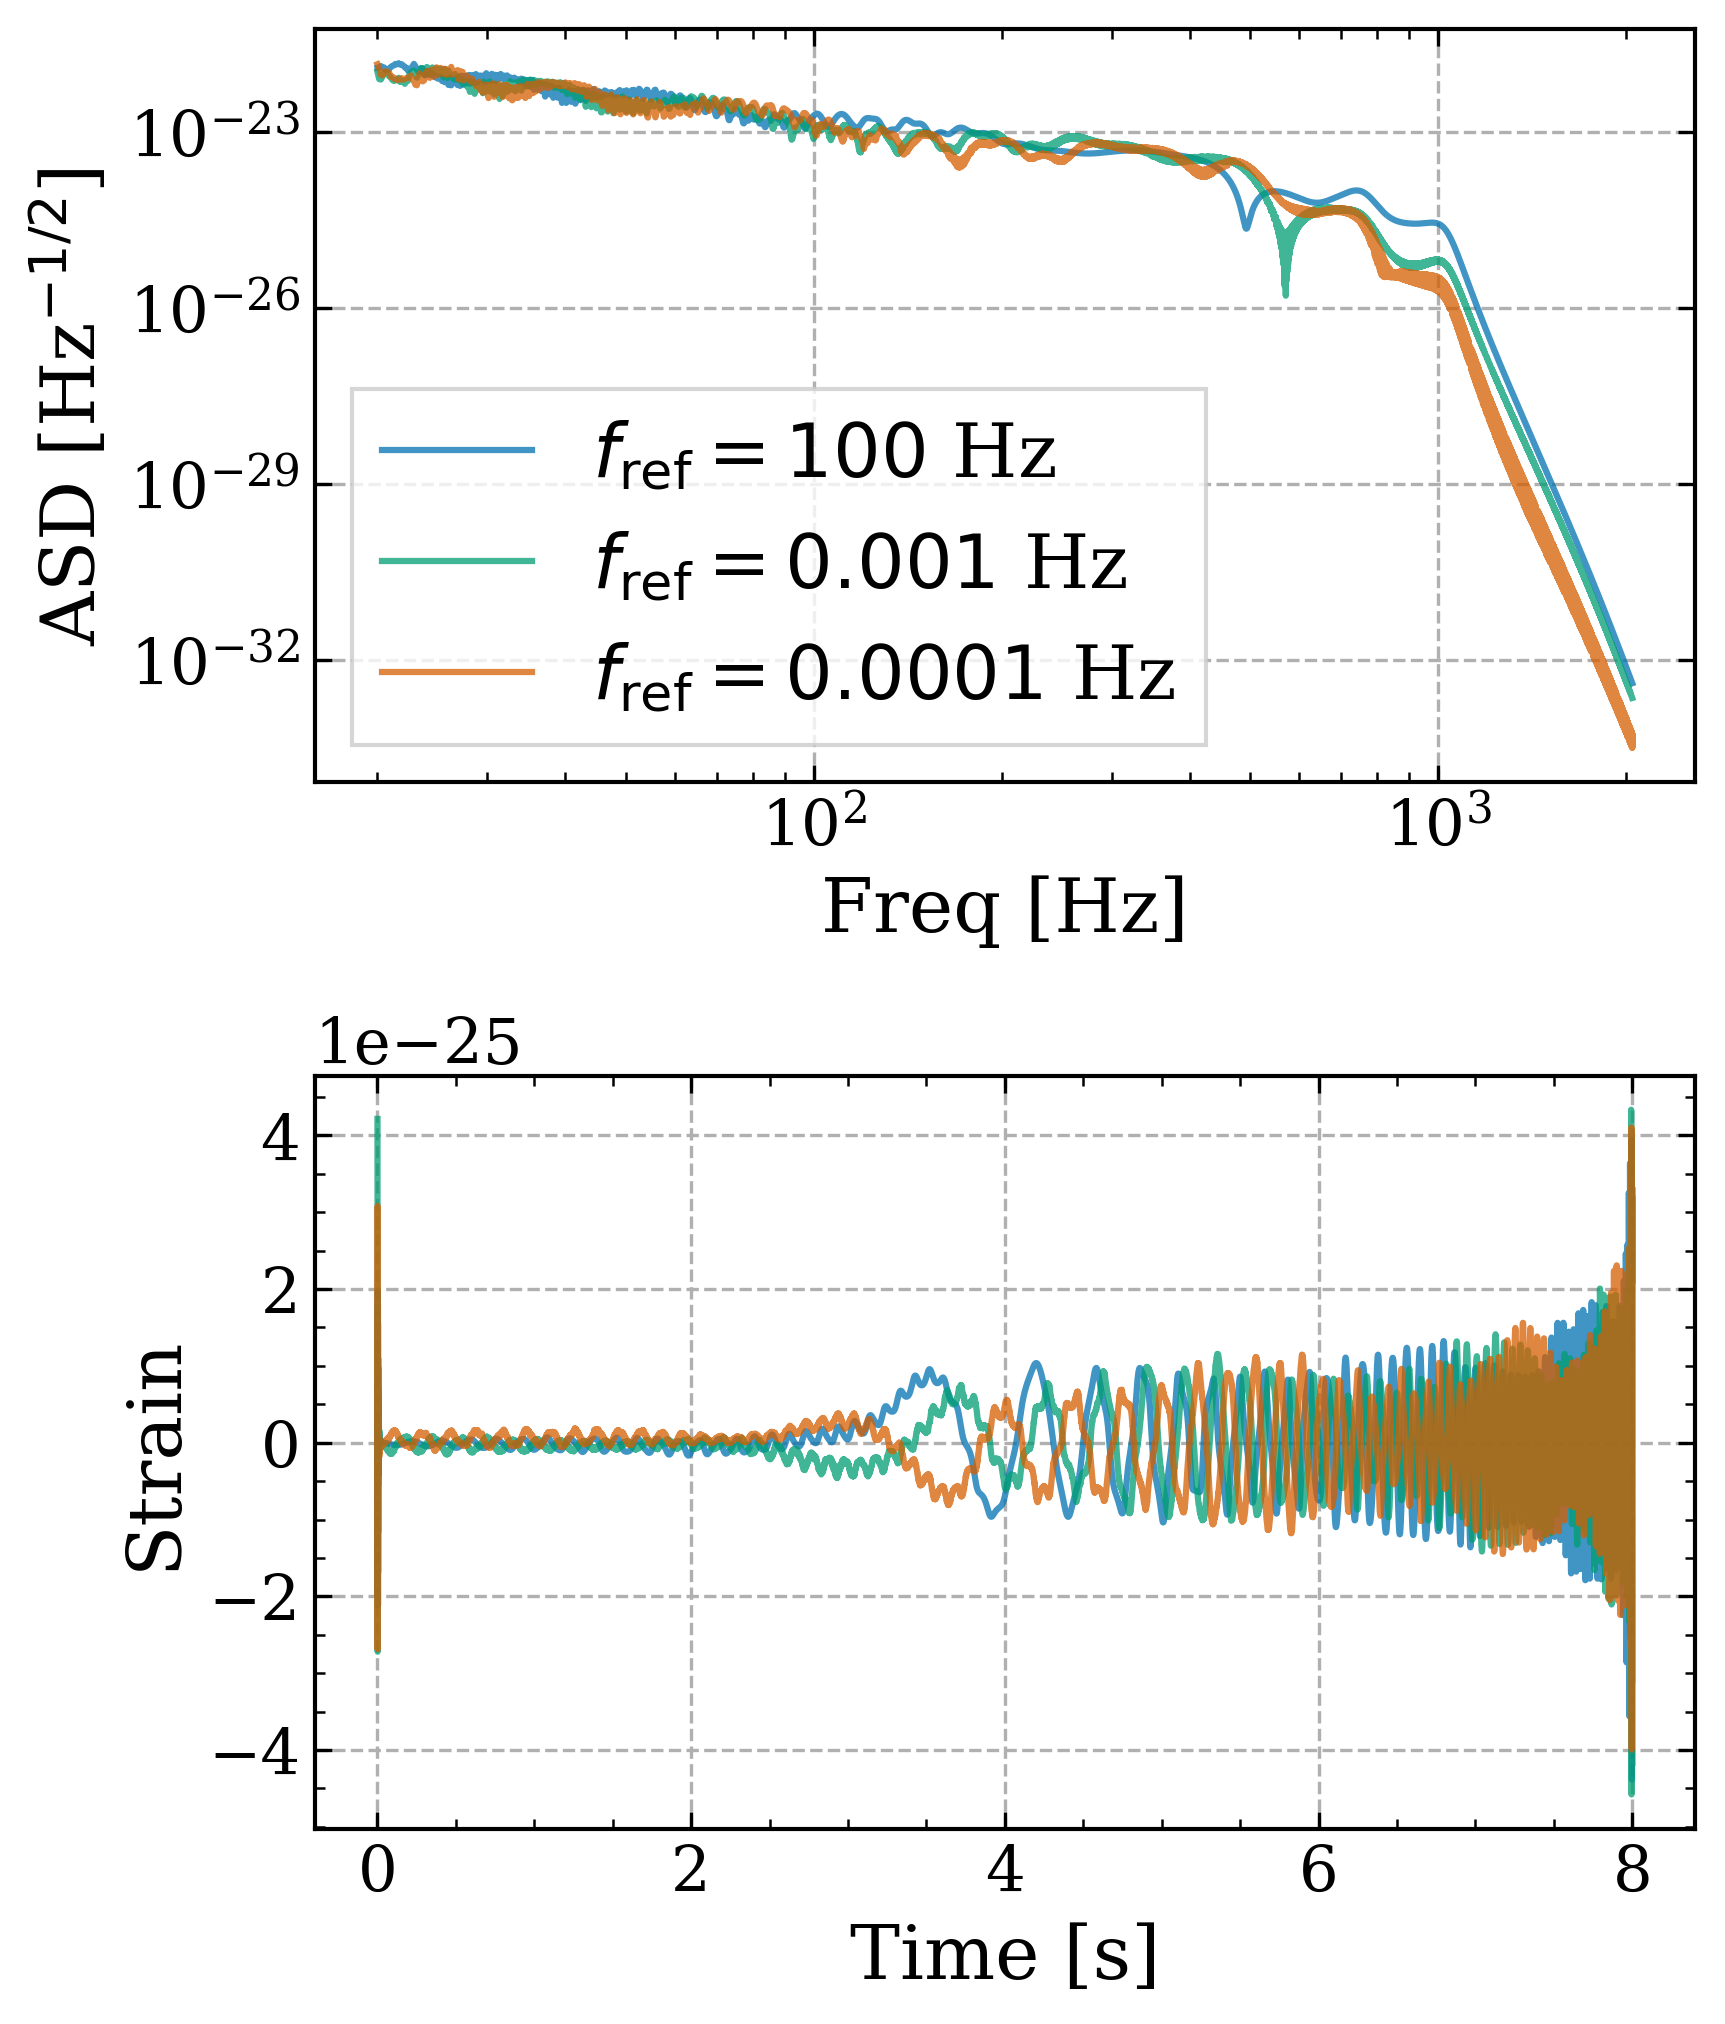

In [114]:
import lal
import lalsimulation as lalsim
import matplotlib.pyplot as plt
plt.style.use(
    "https://gist.githubusercontent.com/avivajpeyi/4d9839b1ceb7d3651cbb469bc6b0d69b/raw/4ee4a870126653d542572372ff3eee4e89abcab0/publication.mplstyle")



def get_fseries_and_tseries(fmin = 20, fmax = 2048, duration = 8.):
    deltaF = 1./duration
    fseries = np.linspace(fmin, fmax, num=int((fmax-fmin)/deltaF)+1)
    tseries = np.linspace(0, duration, num=int((fmax-fmin)/deltaF)*2)
    return fseries, tseries
    
    
def get_strain(fseries, fref=100):
    # injection param
    m1, m2 = 38.90726199927476, 4.099826620277696
    m1*=lal.MSUN_SI
    m2*=lal.MSUN_SI
    s1x, s1y, s1z = -0.5292121532005147, 0.0815506948762848, 0.6489430710417405
    s2x, s2y, s2z = 0.32082521678503834, -0.7843006704918378, 0.02983346070373225
    iota = 2.489741666120003
    phase = 2.3487991630017353
    dist= 100

    
    # convert fseries to lal vector 
    F = fseries
    F = lal.CreateREAL8Vector(len(F))
    F.data[:] =  fseries

    # compute strain 
    WFdict = lal.CreateDict()
    hplus, hcross = lalsim.SimInspiralChooseFDWaveformSequence(
        phase, m1, m2,
        s1x, s1y, s1z,
        s2x, s2y, s2z, 
        fref,
        dist * 1e6 * lal.PC_SI, iota, WFdict,
        lalsim.IMRPhenomXPHM, F
        )
    
    return dict(
        asd = np.abs(hplus.data.data),
        phase = np.unwrap(np.angle(hplus.data.data)),
        time = np.fft.irfft(hplus.data.data)
    )


def plot_strain_at_different_fref(frefs=[]):
    fseries, tseries = get_fseries_and_tseries(duration=8)
    fig, ax = plt.subplots(2,1, figsize=(6,7))

    for fref in frefs:
        strain = get_strain(fseries, fref)
        label = r"$f_{\rm  ref} = " + str(fref) + "$ Hz"
        ax[0].loglog(fseries, strain['asd'], label=label, alpha=0.75)
        ax[1].plot(tseries, strain['time'], label=label, alpha=0.75)
    
    ax[0].set_xlabel('Freq [Hz]')
    ax[1].set_xlabel('Time [s]')
    ax[0].set_ylabel(r'ASD [Hz$^{-1/2}$]')
    ax[1].set_ylabel('Strain')
    ax[0].legend()
    plt.tight_layout()

    
plot_strain_at_different_fref([100, 0.001, 0.0001])
    

In [106]:
strain = get_strain(fseries, fref=100)

plt.plot(data['tim'])